In [1]:
import pandas as pd
import mysql.connector
import warnings 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
warnings.filterwarnings('ignore') 

             Mes_letra  Total_orders  Delinqunet_orders  Delinquency_rate
MONTH                                                                    
2015-07-01       Julio            22                  0            0.0000
2015-08-01      Agosto            52                  1            0.0192
2015-09-01  Septiembre            62                  1            0.0161
2015-10-01     Octubre            58                  2            0.0345
2015-11-01   Noviembre           184                 13            0.0707
2015-12-01   Diciembre           495                 36            0.0727


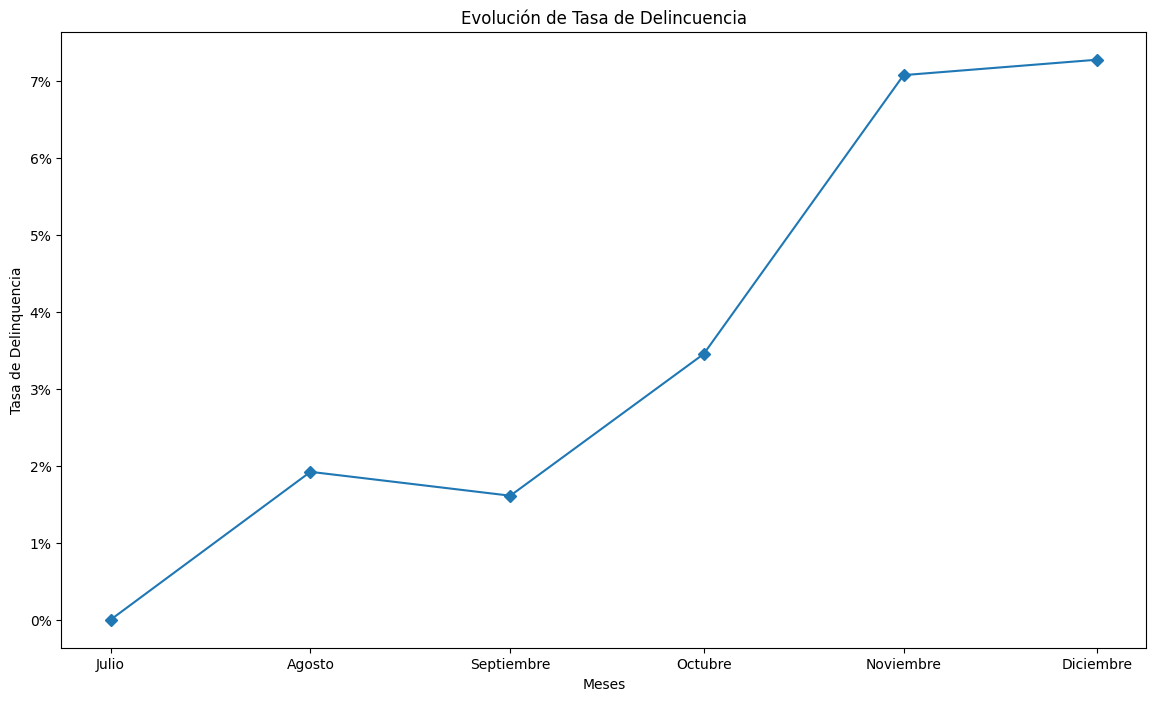

In [3]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="********",
  database="prestamos_2015"
)
query = """
SELECT 
CASE 
WHEN MONTH(created_at) = 12 THEN "Diciembre"
WHEN MONTH(created_at) = 11 THEN "Noviembre"
WHEN MONTH(created_at) = 10 THEN "Octubre"
WHEN MONTH(created_at) = 09 THEN "Septiembre"
WHEN MONTH(created_at) = 08 THEN "Agosto"
ELSE "Julio"
END AS Mes_letra,
MONTH(created_at) AS MONTH,
COUNT(o.order_id) AS Total_orders, COUNT(S1.order_id) AS Delinqunet_orders,
COUNT(S1.order_id) / COUNT(o.order_id) AS Delinquency_rate
FROM Orders as o
LEFT JOIN(
SELECT
created_at AS Month,
order_id
FROM Orders
WHERE status = "DELINQUENT"
) AS S1 
ON o.created_at = S1.Month
GROUP BY 1,2
ORDER BY Delinquency_rate DESC;
"""
#----------
SQL_dataFrame = pd.read_sql(query,mydb)
SQL_dataFrame.MONTH = [f"{x}-01-2015" for x in SQL_dataFrame.MONTH]
SQL_dataFrame.MONTH = pd.to_datetime(SQL_dataFrame.MONTH)
SQL_dataFrame.set_index("MONTH",inplace = True)
SQL_dataFrame.sort_index(inplace = True)
print(SQL_dataFrame)
#--------
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(SQL_dataFrame.index, SQL_dataFrame['Delinquency_rate'], marker='D')
plt.gca().yaxis.set_major_formatter('{x:.0%}')
ax.set_xticklabels(SQL_dataFrame.Mes_letra)

plt.xlabel('Meses')
plt.ylabel('Tasa de Delinquencia')
plt.title('Evolución de Tasa de Delincuencia')

plt.show()

               ESTADO  MONTO_PROMEDIO
0  NO EN DELINCUENCIA      367.634084
1     EN DELINCUENCIA      429.073398


[Text(0, 0, 'NO EN DELINCUENCIA'), Text(1, 0, 'EN DELINCUENCIA')]

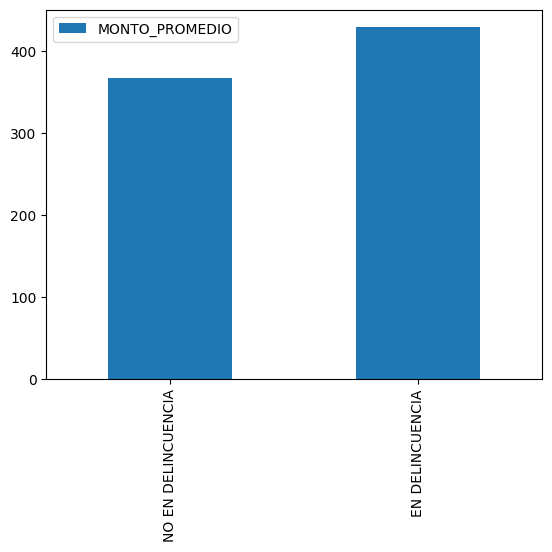

In [13]:
query = """
SELECT 
CASE 
WHEN STATUS = "DELINQUENT" THEN "EN DELINCUENCIA"
ELSE "NO EN DELINCUENCIA"
END AS ESTADO,
AVG(AMOUNT) AS MONTO_PROMEDIO
FROM Orders
GROUP BY 1;
"""
#----------
SQL_dataFrame2 = pd.read_sql(query,mydb)
print(SQL_dataFrame2)
SQL_dataFrame2.plot(kind='bar').set_xticklabels(SQL_dataFrame2.ESTADO)

         TIENDA  cantidad_delinquent  cantidad_no_delinquent  tasa_delinquency
0       Lefties                  1.0                     1.0            0.5000
1        Speedo                  3.0                    11.0            0.2143
2  Leroy Merlin                  1.0                     5.0            0.1667
3        Loreal                  1.0                     5.0            0.1667
4      Havainas                  5.0                    29.0            0.1471


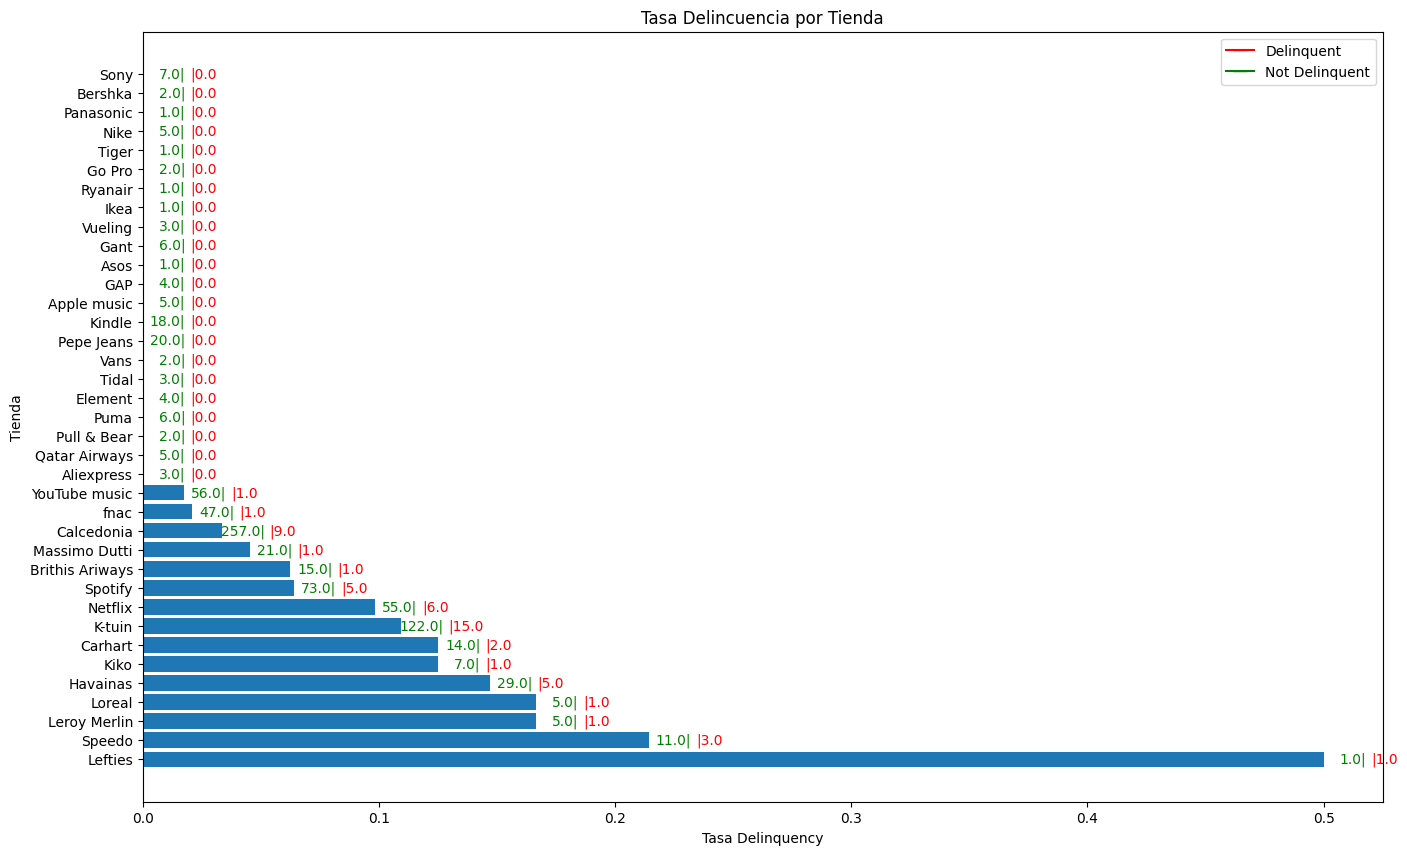

In [80]:
query = """
SELECT 
m.name AS TIENDA,
SUM(CASE WHEN o.STATUS = 'DELINQUENT' THEN 1 ELSE 0 END) AS cantidad_delinquent,
SUM(CASE WHEN o.STATUS != 'DELINQUENT' THEN 1 ELSE 0 END) AS cantidad_no_delinquent,
(SUM(CASE WHEN o.STATUS = 'DELINQUENT' THEN 1 ELSE 0 END) / (SUM(CASE WHEN o.STATUS != 'DELINQUENT' THEN 1 ELSE 0 END)+SUM(CASE WHEN o.STATUS = 'DELINQUENT' THEN 1 ELSE 0 END))) tasa_delinquency
#CONCAT(FORMAT(ROUND(((SUM(CASE WHEN o.STATUS = 'DELINQUENT' THEN 1 ELSE 0 END) / SUM(CASE WHEN o.STATUS != 'DELINQUENT' THEN 1 ELSE 0 END))))*100,2), 2), '%')
FROM 
Orders AS o
LEFT JOIN
Merchants AS m
ON 
m.merchant_id = o.merchant_id
GROUP BY 
 m.name
ORDER BY 
tasa_delinquency DESC;
"""
#----------
SQL_dataFrame3 = pd.read_sql(query,mydb)
print(SQL_dataFrame3.head())

plt.figure(figsize=(16, 10)) 
bars = plt.barh(SQL_dataFrame3.TIENDA, SQL_dataFrame3.tasa_delinquency)
plt.xlabel('Tasa Delinquency')
plt.ylabel('Tienda')
plt.title('Tasa Delincuencia por Tienda')

#for bar, cantidad_delinquent in zip(bars, SQL_dataFrame3.cantidad_delinquent):
for bar, cantidad_delinquent, cantidad_no_delinquent in zip(bars, SQL_dataFrame3.cantidad_delinquent, SQL_dataFrame3.cantidad_no_delinquent):
    plt.text(bar.get_width()+0.02, bar.get_y() + bar.get_height()/2, f'|{cantidad_delinquent}',
             va='center', ha='left', fontsize=10, color='red')
    plt.text(bar.get_width()+0.018, bar.get_y() + bar.get_height()/2, f'{cantidad_no_delinquent}|',
             va='center', ha='right', fontsize=10, color='green')


legend_labels = ['Delinquent','Not Delinquent']
legend_colors = [ 'red','green']
legend_handles = [plt.Line2D([0], [0], marker='_', color=color, label=label, markersize=10) for label, color in zip(legend_labels, legend_colors)]
plt.legend(handles=legend_handles, loc='upper right')
plt.show()

